In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# !pip install -U spacy
# !python -m spacy download en_core_web_sm
import spacy
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from scipy.sparse import hstack
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import warnings
#warnings.filterwarnings('ignore')

In [58]:
# Importing the dataset and  checking the shape of the dataset

#path= r"C:\Users\BIDIT\Downloads\Trilytics competition\Trilytic\AMC_health_and_safety_data.xlsx"
path =r"AMC_health_and_safety_data.xlsx"
df = pd.read_excel(path,na_values=['?',"No Value Found"])
df.shape

(36016, 29)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36016 entries, 0 to 36015
Data columns (total 49 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DOCUMENT_NO          36016 non-null  int64  
 1   SUBUNIT_CD           36016 non-null  int64  
 2   SUBUNIT              36016 non-null  object 
 3   ACCIDENT_DT          36016 non-null  object 
 4   CAL_YR               36016 non-null  int64  
 5   CAL_QTR              36016 non-null  int64  
 6   FISCAL_YR            36016 non-null  int64  
 7   FISCAL_QTR           36016 non-null  int64  
 8   ACCIDENT_TIME        36016 non-null  int64  
 9   DEGREE_INJURY_CD     35970 non-null  float64
 10  DEGREE_INJURY        36016 non-null  object 
 11  FIPS_STATE_CD        36016 non-null  int64  
 12  UG_LOCATION_CD       24492 non-null  float64
 13  UG_LOCATION          36016 non-null  object 
 14  UG_MINING_METHOD_CD  22054 non-null  float64
 15  UG_MINING_METHOD     36016 non-null 

In [8]:
# Removing the columns with more than 50% of missing values
df.dropna(thresh=0.55*len(df), axis=1, inplace=True)

# Checking the number of missing values in each column and show the percentage of missing values
missing=(df.isnull().sum()/len(df)*100).round(2).sort_values(ascending=False)
missing

UG_MINING_METHOD_CD    38.77
UG_LOCATION_CD         32.00
SCHEDULE_CHARGE        27.78
DAYS_RESTRICT          27.70
DAYS_LOST              11.72
RETURN_TO_WORK_DT       8.27
TOT_EXPER               7.58
MINE_EXPER              6.42
JOB_EXPER               6.11
TRANS_TERM              5.11
OCCUPATION_CD           3.43
INJ_BODY_PART_CD        3.42
NATURE_INJURY_CD        3.42
ACTIVITY_CD             3.37
INJURY_SOURCE_CD        3.36
DEGREE_INJURY_CD        0.13
SHIFT_BEGIN_TIME        0.09
ACCIDENT_TYPE           0.06
INJURY_SOURCE           0.00
INJ_BODY_PART           0.00
NATURE_INJURY           0.00
IMMED_NOTIFY_CD         0.00
IMMED_NOTIFY            0.00
NARRATIVE               0.00
COAL_METAL_IND          0.00
ACTIVITY                0.00
DOCUMENT_NO             0.00
OCCUPATION              0.00
ACCIDENT_TIME           0.00
SUBUNIT                 0.00
ACCIDENT_DT             0.00
CAL_YR                  0.00
CAL_QTR                 0.00
FISCAL_YR               0.00
FISCAL_QTR    

In [10]:
#Converting date columns from string to datetime format
df['ACCIDENT_DT'] = pd.to_datetime(df['ACCIDENT_DT'])
df['RETURN_TO_WORK_DT'] = pd.to_datetime(df['RETURN_TO_WORK_DT'])

In [17]:
#Removing duplicate code columns
cd_list = [name for name in df.drop(columns=["FIPS_STATE_CD"],axis=1).columns if name.endswith("CD")]
cd_list

['SUBUNIT_CD',
 'DEGREE_INJURY_CD',
 'UG_LOCATION_CD',
 'UG_MINING_METHOD_CD',
 'OCCUPATION_CD',
 'ACTIVITY_CD',
 'INJURY_SOURCE_CD',
 'NATURE_INJURY_CD',
 'INJ_BODY_PART_CD',
 'IMMED_NOTIFY_CD']

In [19]:
df.drop(columns=cd_list,axis=1,inplace=True)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36016 entries, 0 to 36015
Data columns (total 34 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   DOCUMENT_NO        36016 non-null  int64         
 1   SUBUNIT            36016 non-null  object        
 2   ACCIDENT_DT        36016 non-null  datetime64[ns]
 3   CAL_YR             36016 non-null  int64         
 4   CAL_QTR            36016 non-null  int64         
 5   FISCAL_YR          36016 non-null  int64         
 6   FISCAL_QTR         36016 non-null  int64         
 7   ACCIDENT_TIME      36016 non-null  int64         
 8   DEGREE_INJURY      36016 non-null  object        
 9   FIPS_STATE_CD      36016 non-null  int64         
 10  UG_LOCATION        36016 non-null  object        
 11  UG_MINING_METHOD   36016 non-null  object        
 12  MINING_EQUIP       36016 non-null  object        
 13  EQUIP_MFR_NAME     36016 non-null  object        
 14  SHIFT_

In [32]:
# Assuming your DataFrame is named 'df', loop through each column and calculate the percentage of "NO VALUE FOUND"
columns_with_no_value_found = []
missing_percentages = {}

for column in df.columns:
    if "NO VALUE FOUND" in df[column].values:
        columns_with_no_value_found.append(column)
        missing_count = (df[column] == "NO VALUE FOUND").sum()
        total_count = len(df[column])
        missing_percentage = (missing_count / total_count) * 100
        missing_percentages[column] = missing_percentage

print("Columns with 'NO VALUE FOUND':", columns_with_no_value_found)
print("Percentage of 'NO VALUE FOUND' in each column:")
for column, percentage in missing_percentages.items():
    print(f"{column}: {percentage:.2f}%")

Columns with 'NO VALUE FOUND': ['UG_LOCATION']
Percentage of 'NO VALUE FOUND' in each column:
UG_LOCATION: 32.00%


C:\Users\srija\AppData\Local\Temp\ipykernel_6348\2212940989.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "NO VALUE FOUND" in df[column].values:


In [29]:
# Drop columns with too many no values found
df.drop(columns=["MINING_EQUIP","EQUIP_MFR_NAME","IMMED_NOTIFY"], axis=1, inplace=True, errors="ignore")

In [31]:
for column in df.columns:
    if "NO VALUE FOUND" in df[column].values:
        columns_with_no_value_found.append(column)
        mode_value = df[column].mode().iloc[0]
        df[column] = df[column].replace("NO VALUE FOUND", mode_value)

print("Columns with 'NO VALUE FOUND':", columns_with_no_value_found)
print("Columns after replacing with mode:")
print(df[columns_with_no_value_found])

Columns with 'NO VALUE FOUND': ['DEGREE_INJURY', 'UG_LOCATION', 'UG_MINING_METHOD', 'OCCUPATION', 'ACTIVITY', 'INJURY_SOURCE', 'NATURE_INJURY', 'INJ_BODY_PART', 'DEGREE_INJURY', 'UG_LOCATION', 'UG_MINING_METHOD', 'OCCUPATION', 'ACTIVITY', 'INJURY_SOURCE', 'NATURE_INJURY', 'INJ_BODY_PART']
Columns after replacing with mode:
                        DEGREE_INJURY           UG_LOCATION  \
0      NO DYS AWY FRM WRK,NO RSTR ACT        NO VALUE FOUND   
1            DAYS AWAY FROM WORK ONLY        VERTICAL SHAFT   
2            DAYS AWAY FROM WORK ONLY        NO VALUE FOUND   
3            DAYS AWAY FROM WORK ONLY        NO VALUE FOUND   
4            DAYS AWAY FROM WORK ONLY    LAST OPEN CROSSCUT   
...                               ...                   ...   
36011  INJURIES DUE TO NATURAL CAUSES  SLOPE/INCLINED SHAFT   
36012  NO DYS AWY FRM WRK,NO RSTR ACT        NO VALUE FOUND   
36013  INJURIES DUE TO NATURAL CAUSES        NO VALUE FOUND   
36014        DAYS AWAY FROM WORK ONLY        

C:\Users\srija\AppData\Local\Temp\ipykernel_6348\49279656.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "NO VALUE FOUND" in df[column].values:
C:\Users\srija\AppData\Local\Temp\ipykernel_6348\49279656.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "NO VALUE FOUND" in df[column].values:
C:\Users\srija\AppData\Local\Temp\ipykernel_6348\49279656.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "NO VALUE FOUND" in df[column].values:
C:\Users\srija\AppData\Local\Temp\ipykernel_6348\49279656.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if "NO VALUE FOUND" in df[column].values:


In [37]:
df["UG_LOCATION"].replace("NO VALUE FOUND","FACE", inplace = True)

In [41]:
# Replace missing values in float columns with the median for specified columns
median_impute_columns = ['SCHEDULE_CHARGE', 'DAYS_RESTRICT', 'DAYS_LOST', 'TOT_EXPER', 'MINE_EXPER', 
                         'JOB_EXPER', 'SHIFT_BEGIN_TIME']
df[median_impute_columns] = df[median_impute_columns].fillna(df[median_impute_columns].median())

In [62]:
mode_impute_columns = ['TRANS_TERM','ACCIDENT_TYPE']
df[mode_impute_columns] = df[mode_impute_columns].fillna(df[mode_impute_columns].mode().iloc[0])

In [65]:
df.drop(columns=['SHIFT_BEGIN_TIME',"DOCUMENT_NO","ACCIDENT_DT","RETURN_TO_WORK_DT",'ACCIDENT_TIME'], axis=1, inplace=True, errors="ignore")

In [49]:
nlp = spacy.load("en_core_web_sm")

# Dataframe df with the column narrative containing the sentence
df["tokens"] = df["NARRATIVE"].apply(lambda text: [token.text for token in nlp(text) if not token.is_stop])

In [51]:
# Convert the tokenized text back together
df["processed_narrative"] = df["tokens"].apply(lambda tokens: ' '.join(tokens))

In [67]:
cols = df.columns

In [73]:
def remove_list_from_list(main_list, sublist):
    return [item for item in main_list if item not in sublist]

# Example usage
main_list = cols
sublist = categorical_columns

result = remove_list_from_list(main_list, sublist)
print(result)  # Output: [1, 2, 3, 6, 7]

['CAL_YR', 'FISCAL_YR', 'NO_INJURIES', 'TOT_EXPER', 'MINE_EXPER', 'JOB_EXPER', 'SCHEDULE_CHARGE', 'DAYS_RESTRICT', 'DAYS_LOST', 'NARRATIVE', 'CLASSIFICATION', 'tokens', 'processed_narrative']


In [90]:
# Model-3 Taking all columns
# Separate features (tokenized text) and target (accident classification)
X_text = df["processed_narrative"]
vectorizer = TfidfVectorizer()
X_text_vec = vectorizer.fit_transform(X_text)

# One-hot encode the categorical columns
categorical_columns = ['SUBUNIT', 'DEGREE_INJURY', 'UG_LOCATION', 'FIPS_STATE_CD',
       'ACCIDENT_TYPE', 'OCCUPATION', 'ACTIVITY', 'INJURY_SOURCE','CAL_QTR','FISCAL_QTR',
       'NATURE_INJURY', 'INJ_BODY_PART', 'TRANS_TERM']
encoder = OneHotEncoder(handle_unknown="ignore")
X_categorical = encoder.fit_transform(df[categorical_columns])

numerical_columns = ['CAL_YR' , 'FISCAL_YR', 'NO_INJURIES',
       'TOT_EXPER', 'MINE_EXPER', 'JOB_EXPER', 'SCHEDULE_CHARGE',
       'DAYS_RESTRICT', 'DAYS_LOST']
X_numerical = df[numerical_columns]

# Combine text and categorical features
X_combined = hstack((X_text_vec, X_categorical, X_numerical))

y = df["CLASSIFICATION"]

In [91]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state = 42)

# Train the Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state = 42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.9246252082176568
                                  precision    recall  f1-score   support

                      ELECTRICAL       0.98      0.74      0.84        69
                      ENTRAPMENT       0.96      0.86      0.91        50
EXPLODING VESSELS UNDER PRESSURE       0.00      0.00      0.00        35
  EXPLOSIVES AND BREAKING AGENTS       0.00      0.00      0.00         7
                  FIRE/EXPLOSION       0.87      0.91      0.89       159
           HANDLING OF MATERIALS       0.92      0.98      0.95      4523
                         HAULAGE       0.97      0.72      0.82       760
                      INUNDATION       0.91      0.74      0.82        27
                           OTHER       0.99      0.77      0.87       164
          SLIP OR FALL OF PERSON       0.92      0.94      0.93      1403
                           TOXIC       0.00      0.00      0.00         7

                        accuracy                           0.92      7204
       

C:\Users\srija\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\srija\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\srija\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Confusion Matrix:
[[  51    0    0    0    7   10    0    0    0    1    0]
 [   0   43    0    0    6    0    0    1    0    0    0]
 [   0    0    0    0    0   33    1    0    0    1    0]
 [   0    0    0    0    2    3    1    0    0    1    0]
 [   0    0    0    0  144   13    1    1    0    0    0]
 [   1    0    0    0    2 4420   10    0    1   89    0]
 [   0    0    0    0    0  191  544    0    0   25    0]
 [   0    2    0    0    5    0    0   20    0    0    0]
 [   0    0    0    0    0   34    1    0  126    3    0]
 [   0    0    0    0    0   90    0    0    0 1313    0]
 [   0    0    0    0    0    6    1    0    0    0    0]]


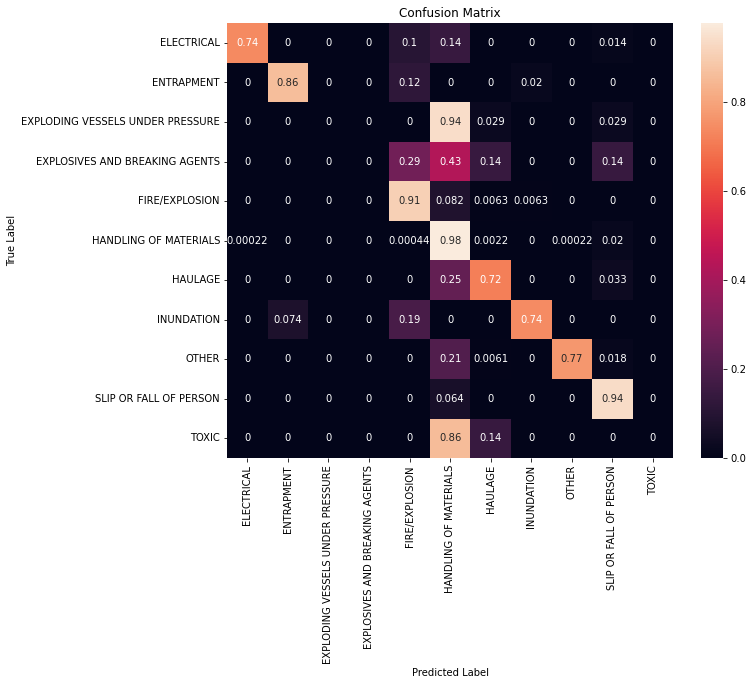

In [92]:
# Print confusion matrix
print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)

row_sums = conf_matrix.sum(axis=1, keepdims=True)
norm_conf_matrix = conf_matrix / row_sums

# Display colored confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(norm_conf_matrix, annot=True, xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [93]:
# Assuming you have true test labels in 'y_test' and predicted probabilities in 'y_pred_probs'
# Convert the true test labels to binary format
y_test_bin = label_binarize(y_test, classes=rf_model.classes_)

# Train a OneVsRestClassifier with the RandomForest model
ovr_rf_model = OneVsRestClassifier(rf_model)
ovr_rf_model.fit(X_train, y_train)

# Predict probabilities for each class
y_pred_probs = ovr_rf_model.predict_proba(X_test)

# Calculate the ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(rf_model.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = roc_auc_score(y_test_bin[:, i], y_pred_probs[:, i])

In [94]:
fpra, tpra, thresholdsa = roc_curve(y_test_bin.ravel(), y_pred_probs.ravel())

# Calculate the overall AUC score
roc_auca = roc_auc_score(y_test_bin, y_pred_probs, average='micro')

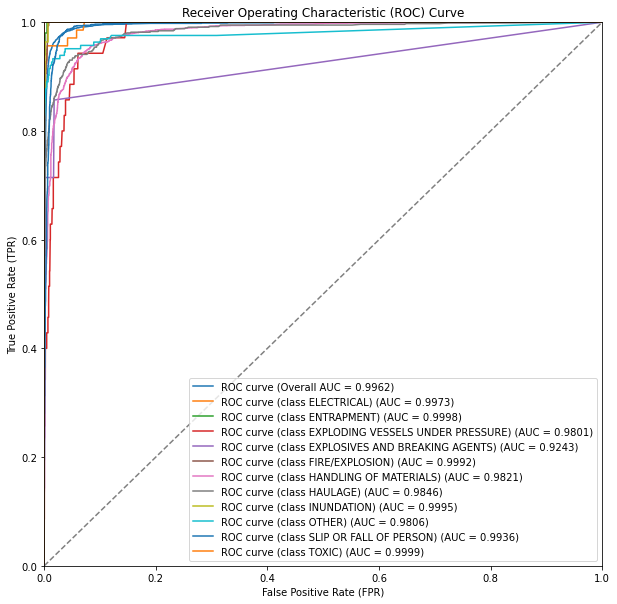

In [97]:
# Plot the ROC curve for each class
plt.figure(figsize=(10, 10))
plt.plot(fpra, tpra , label=f'ROC curve (Overall AUC = {roc_auca:.4f})')

for i in range(len(rf_model.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {rf_model.classes_[i]}) (AUC = {roc_auc[i]:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [103]:
# Get the feature importances
feature_importances_categorical = rf_model.feature_importances_[:len(categorical_columns)]
feature_importances_numerical = rf_model.feature_importances_[-len(numerical_columns):]

# Create a dictionary to associate original feature names with their importances
feature_importances_dict = dict(zip(categorical_columns, feature_importances_categorical))
feature_importances_dict.update(zip(numerical_columns, feature_importances_numerical))

# Print the feature importances for the original columns
for feature, importance in feature_importances_dict.items():
    print(f"{feature}: {importance}")

SUBUNIT: 0.00022957079855731604
DEGREE_INJURY: 9.20160377473238e-06
UG_LOCATION: 1.0395236178345614e-06
FIPS_STATE_CD: 3.656250145723766e-06
ACCIDENT_TYPE: 6.0139266189495435e-05
OCCUPATION: 7.137932975658732e-05
ACTIVITY: 4.109441873011325e-05
INJURY_SOURCE: 1.142141116651238e-06
CAL_QTR: 9.89900155280298e-06
FISCAL_QTR: 4.002526853204774e-06
NATURE_INJURY: 8.298537584173732e-07
INJ_BODY_PART: 2.9073271564602426e-07
TRANS_TERM: 7.051773265152779e-06
CAL_YR: 0.004641459818716856
FISCAL_YR: 0.004592795756318129
NO_INJURIES: 0.007964814525926945
TOT_EXPER: 0.005190639223842053
MINE_EXPER: 0.005671641575502623
JOB_EXPER: 0.005589785518282776
SCHEDULE_CHARGE: 0.0008352865377574337
DAYS_RESTRICT: 0.0012780843686602094
DAYS_LOST: 0.0061579527125272746


In [98]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print(classification_report(y_test, y_pred))

Accuracy: 0.9246252082176568
                                  precision    recall  f1-score   support

                      ELECTRICAL       0.98      0.74      0.84        69
                      ENTRAPMENT       0.96      0.86      0.91        50
EXPLODING VESSELS UNDER PRESSURE       0.00      0.00      0.00        35
  EXPLOSIVES AND BREAKING AGENTS       0.00      0.00      0.00         7
                  FIRE/EXPLOSION       0.87      0.91      0.89       159
           HANDLING OF MATERIALS       0.92      0.98      0.95      4523
                         HAULAGE       0.97      0.72      0.82       760
                      INUNDATION       0.91      0.74      0.82        27
                           OTHER       0.99      0.77      0.87       164
          SLIP OR FALL OF PERSON       0.92      0.94      0.93      1403
                           TOXIC       0.00      0.00      0.00         7

                        accuracy                           0.92      7204
       

C:\Users\srija\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\srija\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\srija\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
